In [1]:
# ------------------------------
# STEP 0: Mount Google Drive
# ------------------------------
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import csv
from pathlib import Path
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch.nn as nn


### 🔧 Step 1: Configure data paths and parameters

This cell defines the paths to training and test datasets, as well as the corresponding label sheets for training images.  

Each training folder is expected to contain:
- the TEM images (e.g., `.tif`, `.jpg`),
- a structured label file (Google Sheet, `.csv`, or `.xlsx`) with class names in **textual form**.

The structure includes:
- `TRAIN_DIRS`: paths to training image folders,
- `LABEL_SHEETS`: paths to label files matching each folder,
- `TEST_DIRS`: folders with **unseen test images** (no labels),
- `CLASS_LABELS`: dictionary of all available classes (as text),
- core parameters for model training.


In [3]:
# ------------------------------
# STEP 1: Configuration of paths and parameters
# ------------------------------

# 📁 Training image folders
TRAIN_DIRS = [
    "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_01_01_UO_TEM",
    "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_02_01_UO_TEM",
    "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_02_04_UO_TEM",
    "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_G_02_01_TEM",
]

FOLDER_MAP = {
    os.path.basename(folder).split("_UO_TEM")[0]: folder
    for folder in TRAIN_DIRS
}

# 📄 Google Sheet label files (aligned with TRAIN_DIRS)
LABEL_SHEETS = [
    "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_01_01_UO_TEM/AC_UT_GO_01_01_UO_TEM.csv",
    "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_02_01_UO_TEM/AC_UT_GO_02_01_UO_TEM.csv",
    "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_02_04_UO_TEM/AC_UT_GO_02_04_UO_TEM.csv",
    "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_02_04_UO_TEM/AC_UT_G_02_01_TEM.csv"
]

# 📁 Test image folders (unlabeled)
TEST_DIRS = [
    "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_G_03_01_TEM",
    "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_G_04_01_TEM",
    "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_02_02_UO_TEM",
    "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_02_03_UO_TEM",
    "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_09_03_F_02_TEM",
    "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_06_01_F_01_TEM",
]

# 🏷️ Dictionary of valid text labels per classification task
CLASS_LABELS = {
    "Image Type": ["BF", "DP", "Combination", "Other"],
    "Nanostructures": ["No", "One", "Few (<10)", "Many (>10)", "NA"],
    "Morphology": [
        "Thick flat rigid", "Thin flat or wavy with few kinks",
        "Thin crumpled with many folds and kinks",
        "Combination", "Other", "Disorganised Graphene", "NA"
    ],
    "Num_particles": [
        "None", "One", "Part of one or more",
        "Few (2...10)", "Many (>10)", "NA"
    ],
    "Num_materials": [
        "One", "More than one", "Obvious impurities or contamination", "NA"
    ],
    "Usability": ["Yes", "No"]
}

# 📂 Output directory root (each material gets its own subfolder)
OUTPUT_BASE_DIR = "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/processed"

# 📐 Model hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

### ✅ Step 0 Helper functions: Check data folders and label sheets


In [4]:
import re

def extract_magnification(filename):
    """Extracts magnification from filename like '_2000X_' and returns it as float normalized."""
    match = re.search(r'_(\d+)X_', filename)
    if match:
        return int(match.group(1)) / 200000.0  # Zakładamy max 200000X
    return 0.0

In [5]:
def read_csv_auto(path, **kwargs):
    with open(path, 'r', encoding='utf-8') as f:
        sample = f.read(2048)
        try:
            dialect = csv.Sniffer().sniff(sample)
            sep = dialect.delimiter
        except csv.Error:
            sep = ','  # fallback if detection fails

    return pd.read_csv(path, sep=sep, **kwargs)


# ✅ Step 1 Test: Check data folders and label sheets

This cell verifies that:
- all training image folders exist and contain supported image files (`.tif`, `.jpg`, `.png`),
- all linked Google Sheets (or CSVs) are accessible and readable,
- label sheets have content and load into a DataFrame.

It prints a summary for each training folder.



In [6]:
# Accepted image extensions
image_exts = (".tif", ".tiff", ".jpg", ".jpeg", ".png")

print("🔍 Checking training folders and label sheets...\n")

for dir_path, sheet_path in zip(TRAIN_DIRS, LABEL_SHEETS):
    print(f"📁 Folder: {dir_path}")

    # Count images
    try:
        image_files = [f for f in os.listdir(dir_path) if f.lower().endswith(image_exts)]
        print(f"  ➤ {len(image_files)} image files found.")
    except Exception as e:
        print(f"  ⚠️ Could not access folder: {e}")

    # Load label sheet
    try:
        if sheet_path.endswith(".csv"):
            df = read_csv_auto(sheet_path)
        elif sheet_path.endswith(".xlsx"):
            df = pd.read_excel(sheet_path)
        elif sheet_path.endswith(".gsheet"):
            # Convert .gsheet to actual link if needed
            print(f"  ⚠️ Direct reading of .gsheet files requires manual export or Google Sheets API access.")
            df = None
        else:
            print(f"  ⚠️ Unsupported sheet format: {sheet_path}")
            df = None

        if df is not None:
            print(f"  ✅ Loaded label sheet with shape: {df.shape}")
            display(df.head(5))
        else:
            print("  ⚠️ Label sheet was not loaded.")

    except Exception as e:
        print(f"  ❌ Error loading label sheet: {e}")

    print("-" * 60)


🔍 Checking training folders and label sheets...

📁 Folder: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_01_01_UO_TEM
  ➤ 47 image files found.
  ✅ Loaded label sheet with shape: (47, 7)


,filename,Image Type,Usability,Num_particles,Num_materials,Morphology,Nanostructures
0,AC_UT_GO_01_01_1200000X_0006.tif,BF,Yes,Part of one or more,One,Other,Few (<10)
1,AC_UT_GO_01_01_1200000X_0007.tif,BF,Yes,Part of one or more,One,Other,Few (<10)
2,AC_UT_GO_01_01_1200000X_0017.tif,BF,Yes,Part of one or more,One,Thin flat or wavy with few kinks,Few (<10)
3,AC_UT_GO_01_01_1200000X_0018.tif,BF,No,Part of one or more,One,Other,No
4,AC_UT_GO_01_01_1200000X_0019.tif,BF,No,Part of one or more,One,Other,No


------------------------------------------------------------
📁 Folder: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_02_01_UO_TEM
  ➤ 51 image files found.
  ✅ Loaded label sheet with shape: (45, 7)


,filename,Image Type,Usability,Num_particles,Num_materials,Morphology,Nanostructures
0,AC_UT_GO_02_01_1200000X_0006.tif,BF,Yes,Part of one or more,One,Other,Few (<10)
1,AC_UT_GO_02_01_1200000X_0007.tif,BF,Yes,Part of one or more,One,Other,Few (<10)
2,AC_UT_GO_02_01_1200000X_0008.tif,BF,Yes,Part of one or more,One,Other,Few (<10)
3,AC_UT_GO_02_01_1200000X_0009.tif,BF,Yes,Part of one or more,One,Disorganised Graphene,No
4,AC_UT_GO_02_01_1200000X_0025.tif,BF,Yes,Part of one or more,One,Thin flat or wavy with few kinks,No


------------------------------------------------------------
📁 Folder: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_02_04_UO_TEM
  ➤ 40 image files found.
  ✅ Loaded label sheet with shape: (40, 7)


,filename,Image Type,Usability,Num_particles,Num_materials,Morphology,Nanostructures
0,AC_UT_GO_02_04_1200000X_0012.tif,BF,Yes,Part of one or more,One,NaN,No
1,AC_UT_GO_02_04_1200000X_0013.tif,BF,Yes,Part of one or more,One,NaN,No
2,AC_UT_GO_02_04_1200000X_0014.tif,BF,Yes,Part of one or more,One,Thin flat or wavy with few kinks,No
3,AC_UT_GO_02_04_1200000X_0015.tif,BF,Yes,Part of one or more,One,Thin flat or wavy with few kinks,No
4,AC_UT_GO_02_04_1200000X_0024.tif,BF,Yes,Part of one or more,One,Other,No


------------------------------------------------------------
📁 Folder: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_G_02_01_TEM
  ➤ 47 image files found.
  ❌ Error loading label sheet: [Errno 2] No such file or directory: '/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_02_04_UO_TEM/AC_UT_G_02_01_TEM.csv'
------------------------------------------------------------


# 🧩 Step 2: Merge label CSVs and encode text classes

This step performs the following:
1. Loads all `.csv` label sheets listed in `LABEL_SHEETS`.
2. Appends a `material_name` column extracted from the folder name (for filtering or tracking).
3. Merges all rows into a single unified DataFrame.
4. Encodes all textual class labels using the dictionary `CLASS_LABELS`, converting them into integer class indices.

The resulting DataFrame will be ready for training and validation. The validation is as follows:

**Matched / Unmatched**

Matched indicates how many unique category values in that column were successfully recognized as valid (e.g., “Yes/No” in Usability, or “Part of one or more / One / Few / Many” in Num_particles).

Unmatched indicates values that did not match the predefined categories, suggesting possible typos, formatting inconsistencies, or labels outside the expected scheme.

For example:

🔹 Morphology: 3 matched / 0 unmatched

means that three distinct morphology classes were found in this CSV file, and all of them are valid (no unexpected labels).

In [7]:

# Container for all labeled data
all_labeled_data = []

# For unmatched value reporting
unmatched_summary = []

print("🔎 Starting label sheet parsing and encoding...\n")

for dir_path, sheet_path in zip(TRAIN_DIRS, LABEL_SHEETS):
    try:
        df = pd.read_csv(sheet_path)
        material_name = Path(dir_path).name
        df["material_name"] = material_name

        # Clean column names
        df.columns = df.columns.str.strip()

        print(f"📄 Processing: {sheet_path}")
        print(f"   ➤ Found {df.shape[0]} rows")

        # Encode each column using CLASS_LABELS
        for column, class_list in CLASS_LABELS.items():
            if column not in df.columns:
                print(f"   ⚠️ Column not found: '{column}' — skipped.")
                continue

            label_map = {v: i for i, v in enumerate(class_list)}
            encoded_col = df[column].map(label_map)

            # Report values
            unique_original = set(df[column].dropna().unique())
            matched = set(label_map.keys()) & unique_original
            unmatched = unique_original - set(label_map.keys())

            print(f"   🔹 {column}: {len(matched)} matched / {len(unmatched)} unmatched")

            if unmatched:
                unmatched_counts = df[column].value_counts().to_dict()
                for val in unmatched:
                    count = unmatched_counts.get(val, 0)
                    unmatched_summary.append({
                        "file": Path(sheet_path).name,
                        "column": column,
                        "value": val,
                        "count": count
                    })
                    print(f"     ✖ Unmatched value: '{val}' (count: {count})")

            df[column + "_encoded"] = encoded_col

        all_labeled_data.append(df)
        print("   ✅ Done.\n")

    except Exception as e:
        print(f"❌ Failed to process {sheet_path}: {e}\n")

# Merge into a single DataFrame
if all_labeled_data:
    labels_df = pd.concat(all_labeled_data, ignore_index=True)
    print(f"\n✅ Combined label dataset shape: {labels_df.shape}")
    display(labels_df)
else:
    print("❌ No label data was successfully loaded.")

# Display unmatched value summary if any
if unmatched_summary:
    unmatched_df = pd.DataFrame(unmatched_summary)
    print("\n⚠️ Unmatched values summary:")
    display(unmatched_df)
else:
    print("\n✅ All labels matched successfully.")


🔎 Starting label sheet parsing and encoding...

📄 Processing: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_01_01_UO_TEM/AC_UT_GO_01_01_UO_TEM.csv
   ➤ Found 47 rows
   🔹 Image Type: 2 matched / 0 unmatched
   🔹 Nanostructures: 4 matched / 0 unmatched
   🔹 Morphology: 3 matched / 0 unmatched
   🔹 Num_particles: 3 matched / 0 unmatched
   🔹 Num_materials: 2 matched / 0 unmatched
   🔹 Usability: 2 matched / 0 unmatched
   ✅ Done.

📄 Processing: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/raw/AC_UT_GO_02_01_UO_TEM/AC_UT_GO_02_01_UO_TEM.csv
   ➤ Found 45 rows
   🔹 Image Type: 2 matched / 0 unmatched
   🔹 Nanostructures: 4 matched / 0 unmatched
   🔹 Morphology: 4 matched / 0 unmatched
   🔹 Num_particles: 3 matched / 0 unmatched
   🔹 Num_materials: 2 matched / 0 unmatched
   🔹 Usability: 1 matched / 0 unmatched
   ✅ Done.

📄 Processing: /content/drive/MyDrive/02 ACCORDS/ACC_ImageChara

,filename,Image Type,Usability,Num_particles,Num_materials,Morphology,Nanostructures,material_name,Image Type_encoded,Nanostructures_encoded,Morphology_encoded,Num_particles_encoded,Num_materials_encoded,Usability_encoded
0,AC_UT_GO_01_01_1200000X_0006.tif,BF,Yes,Part of one or more,One,Other,Few (<10),AC_UT_GO_01_01_UO_TEM,0,2.0,4.0,2.0,0.0,0.0
1,AC_UT_GO_01_01_1200000X_0007.tif,BF,Yes,Part of one or more,One,Other,Few (<10),AC_UT_GO_01_01_UO_TEM,0,2.0,4.0,2.0,0.0,0.0
2,AC_UT_GO_01_01_1200000X_0017.tif,BF,Yes,Part of one or more,One,Thin flat or wavy with few kinks,Few (<10),AC_UT_GO_01_01_UO_TEM,0,2.0,1.0,2.0,0.0,0.0
3,AC_UT_GO_01_01_1200000X_0018.tif,BF,No,Part of one or more,One,Other,No,AC_UT_GO_01_01_UO_TEM,0,0.0,4.0,2.0,0.0,1.0
4,AC_UT_GO_01_01_1200000X_0019.tif,BF,No,Part of one or more,One,Other,No,AC_UT_GO_01_01_UO_TEM,0,0.0,4.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,AC_UT_GO_02_04_500000X_0030.tif,BF,Yes,Part of one or more,One,Other,No,AC_UT_GO_02_04_UO_TEM,0,0.0,4.0,2.0,0.0,0.0
128,AC_UT_GO_02_04_500000X_0037.tif,BF,Yes,Part of one or more,One,NaN,No,AC_UT_GO_02_04_UO_TEM,0,0.0,NaN,2.0,0.0,0.0
129,AC_UT_GO_02_04_600X_0009.tif,DP,Yes,NaN,NaN,NaN,NaN,AC_UT_GO_02_04_UO_TEM,1,NaN,NaN,NaN,NaN,0.0
130,AC_UT_GO_02_04_600X_0016.tif,DP,Yes,NaN,NaN,NaN,NaN,AC_UT_GO_02_04_UO_TEM,1,NaN,NaN,NaN,NaN,0.0



✅ All labels matched successfully.


# 🧩 Step 3: Define CustomDataset for multi-task classification

A custom dataset is implemented to link image files with their encoded labels from `labels_df`.  
For each sample it:
- Locates the image file by matching filename with the training folders,
- Applies a chosen transform (resize, normalization, augmentation),
- Returns a tuple: `(image tensor, encoded label tensor, filename)`.

This dataset class serves as the foundation for the training, validation, and inference pipelines.



In [8]:
# Column list for labels
TASK_COLUMNS = [col + "_encoded" for col in CLASS_LABELS.keys()]


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")
        label = torch.tensor(self.labels[index], dtype=torch.long)

        # Extract magnification from file name since it might be usefull to use in image recognition
        magnification = extract_magnification(image_path)
        magnification = torch.tensor([magnification], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, magnification, label

    def __len__(self):
        return len(self.image_paths)


# 🧪 Step 4: Define transforms and create DataLoaders

In this step, we set up the **data preprocessing and loading pipeline** for training and validation.

---

### 1. Image transformations
- **ImageNet normalization**  
  The same mean and std values used for ImageNet-pretrained models:  
  `mean = [0.485, 0.456, 0.406]`, `std = [0.229, 0.224, 0.225]`.

- **Training transform (data augmentation):**
  - Resize all images to `(IMG_SIZE, IMG_SIZE)`.
  - Random horizontal/vertical flips.
  - Random rotation (±20 degrees).
  - Random color jitter (brightness & contrast).
  - Convert to tensor and normalize.

- **Validation/test transform:**
  - Only resize, convert to tensor, and normalize (no augmentation).

---

### 2. Train/validation split
- The dataset (`labels_df`) is split into **80% training / 20% validation**.  
- The split is **stratified** by one column (`Image Type_encoded`) to keep label distribution balanced across sets.  
- Each sample gets its image path via `filename_to_path`.

- Missing values in label columns (`TASK_COLUMNS`) are replaced with `-1` to ensure valid tensors.

---

### 3. Dataset & DataLoader
- **CustomDataset** wraps the images and labels, applying the chosen transform.
- Two datasets are created:
  - `train_dataset` with augmentation,  
  - `val_dataset` with only normalization.
- **DataLoader** is used to batch and shuffle the data:
  - `train_loader` → shuffles samples each epoch,  
  - `val_loader` → deterministic order (no shuffle).

---

### ✅ Final outcome
- Training set: `len(train_dataset)` samples.  
- Validation set: `len(val_dataset)` samples.  
- Ready-to-use `train_loader` and `val_loader` feeding data batches directly to the model.


In [9]:
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import os

label_cols = [col for col in labels_df.columns if col.endswith("_encoded")]


# 💡 Standard ImageNet normalization
imagenet_norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std =[0.229, 0.224, 0.225]
)

# 🔧 Augmented + normalized training transform
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    imagenet_norm
])

# 🔍 Minimal validation/test transform with normalization only
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    imagenet_norm
])


# Stratified split based on one task (e.g., 'Image type_encoded')
stratify_col = "Image Type_encoded"
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df[stratify_col],
    random_state=42
)


def filename_to_path(filename):
    for prefix, base_dir in FOLDER_MAP.items():
        if filename.startswith(prefix):
            return os.path.join(base_dir, filename)
    return None  # na wypadek braku dopasowania

# dodaj kolumnę 'path' do dataframe'ów
train_df["path"] = train_df["filename"].apply(filename_to_path)
val_df["path"] = val_df["filename"].apply(filename_to_path)

# Fill NaN values in encoded label columns with -1
for col in TASK_COLUMNS:
    train_df[col] = train_df[col].fillna(-1)
    val_df[col] = val_df[col].fillna(-1)


# (opcjonalnie) sprawdź czy wszystkie ścieżki są OK
print(train_df["path"].head(3))

train_dataset = CustomDataset(train_df["path"].tolist(), train_df[label_cols].values, transform=train_transform)
val_dataset   = CustomDataset(val_df["path"].tolist(),   val_df[label_cols].values,   transform=val_transform)

# 🧱 Wrap in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Train set: {len(train_dataset)} samples")
print(f"✅ Validation set: {len(val_dataset)} samples")

94     /content/drive/MyDrive/02 ACCORDS/ACC_ImageCha...
64     /content/drive/MyDrive/02 ACCORDS/ACC_ImageCha...
121    /content/drive/MyDrive/02 ACCORDS/ACC_ImageCha...
Name: path, dtype: object
✅ Train set: 105 samples
✅ Validation set: 27 samples


# 🧠 Step 5: Define Multi-Task Classification Model with EfficientNet Backbone

This model uses a shared **EfficientNet backbone** to extract image features and then passes those features into multiple classification heads — one per task.

Each head is a simple linear classifier predicting one of the following:
- `Image type`
- `Nanostructures`
- `Morphology`
- `Num_particles`
- `Num_materials`
- `Usability`

The backbone is loaded with pretrained weights, and the final layer is removed so we can reuse its feature extractor output.

## 🏗️ Backbone Architectures in `get_backbone`

The function `get_backbone` provides access to several well-known CNN backbones from the `torchvision` library.  
Each backbone has a different origin, design philosophy, and complexity.

---

#### 1. ResNet18
- **Introduced by:** Kaiming He et al., 2015 ("Deep Residual Learning for Image Recognition", CVPR 2016).  
- **Key idea:** *Residual connections* (skip connections) to ease training of deep networks by mitigating vanishing gradients.  
- **Architecture:**  
  - 18 layers deep (basic residual blocks with 2 convolutional layers each).  
  - Uses global average pooling before the final fully connected (FC) layer.  
- **Impact:** First model to make *very deep networks* trainable effectively; won ILSVRC 2015.

---

#### 3. EfficientNet-B0
- **Introduced by:** Mingxing Tan & Quoc V. Le, 2019 ("EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks").  
- **Key idea:** *Compound scaling* of depth, width, and resolution in a principled way instead of arbitrarily increasing depth.  
- **Architecture:**  
  - Based on **MBConv blocks** (mobile inverted bottleneck convolutions with depthwise separable convolutions).  
  - B0 is the baseline; larger variants (B1–B7) are scaled systematically.  
- **Impact:** Much better accuracy–efficiency trade-off than previous models; widely used for mobile/efficient inference.

---

#### 4. ConvNeXt-Tiny
- **Introduced by:** Zhuang Liu et al., 2022 ("A ConvNet for the 2020s").  
- **Key idea:** Redesign convolutional networks with inspiration from the **Vision Transformer (ViT)** architecture, but keeping convolutional operations.  
- **Architecture:**  
  - Purely convolutional, but with design choices similar to Transformers (e.g., patchify stem, large kernel depthwise convolutions, layer normalization).  
  - Tiny variant (~29M parameters, 768-dim features).  
- **Impact:** Showed that with modern design, ConvNets can match or surpass Transformers on image classification benchmarks.

---

### 🔑 Summary of Differences
| Backbone        | Year | Authors (Origin)           | Depth   | Main Innovation                  |
|-----------------|------|----------------------------|---------|----------------------------------|
| ResNet18        | 2015 | He et al. (Microsoft)      | 18      | Residual (skip) connections      |
| EfficientNet-B0 | 2019 | Tan & Le (Google Brain)    | ~237 MBConv ops | Compound scaling, MBConv blocks |
| ConvNeXt-Tiny   | 2022 | Liu et al. (FAIR, Meta AI) | ~29M params | ConvNet redesigned with ViT ideas |

Each architecture reflects a **generation of CNN design**:  
- **ResNets (2015):** stability and scalability of deep networks.  
- **EfficientNet (2019):** principled scaling with efficiency.  
- **ConvNeXt (2022):** modernization of ConvNets inspired by Transformers.

In [10]:
from torchvision.models import (
    resnet18, ResNet18_Weights,
    resnet34, ResNet34_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
    convnext_tiny, ConvNeXt_Tiny_Weights
)

def get_backbone(name, pretrained=True):
    if name == "resnet18":
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        model = resnet18(weights=weights)
        features = nn.Sequential(*list(model.children())[:-1])
        in_features = model.fc.in_features

    elif name == "resnet34":
        weights = ResNet34_Weights.DEFAULT if pretrained else None
        model = resnet34(weights=weights)
        features = nn.Sequential(*list(model.children())[:-1])
        in_features = model.fc.in_features

    elif name == "efficientnet_b0":
        weights = EfficientNet_B0_Weights.DEFAULT if pretrained else None
        model = efficientnet_b0(weights=weights)
        features = model.features
        in_features = model.classifier[1].in_features

    elif name == "convnext_tiny":
        weights = ConvNeXt_Tiny_Weights.DEFAULT if pretrained else None
        model = convnext_tiny(weights=weights)
        features = model.features
        in_features = model.classifier[2].in_features

    else:
        raise ValueError(f"Unsupported model: {name}")

    return features, in_features


### 🧶 Tensor Flow Diagram — Image + Metadata Fusion (MultiTaskModelWithMagnification)

T### 🧩 MultiTaskModelWithMagnification — Explanation

This model is designed for **multi-task image classification** while also incorporating **metadata (magnification)** as an additional input. It combines a CNN backbone with a small metadata branch and produces predictions for multiple tasks simultaneously.  

---

#### Key components

1. **Backbone feature extractor**
   - A standard CNN (ResNet, EfficientNet, ConvNeXt, etc.) is used to extract features from input images.  
   - The classification head of the backbone is removed; only the convolutional layers remain.  
   - Global average pooling reduces spatial dimensions, producing a single feature vector for each image.  

2. **Metadata branch**
   - A simple fully connected layer (`Linear(1 → 32) + ReLU`) processes the magnification value.  
   - This transforms the single scalar into a 32-dimensional feature vector.  

3. **Feature fusion**
   - The image features and metadata features are concatenated into one combined representation.  
   - Example: if the backbone produces a 512-dim vector, the combined representation will have 512 + 32 = 544 dimensions.  

4. **Task-specific heads**
   - For each classification task in `CLASS_LABELS`, the model includes a separate linear head.  
   - Each head maps the shared representation into logits for the corresponding number of classes.  
   - This allows the model to **share information across tasks**, while still producing independent predictions per task.  

5. **Forward pass**
   - **Input:** `(image, magnification)`  
   - **Output:** a dictionary `{task_name: logits}`, where each task has its own prediction.  

---

#### Why this design?
- **Shared backbone:** avoids training a separate CNN for each task, saving computation and data.  
- **Metadata fusion:** magnification may strongly affect image appearance; including it helps the model disambiguate cases.  
- **Multi-head setup:** enables simultaneous predictions for multiple properties of the same image (*multi-task learning*).  



```text
Input Image (x_img)                      Metadata (x_meta)
[B, C, H, W]                              [B, 1]
        │                                       │
        ▼                                       ▼
+-------------------+                   +------------------+
|   CNN Backbone    |                   |   Meta FC (1→32) |
|  get_backbone()   |                   | Linear + ReLU    |
+-------------------+                   +------------------+
        │                                       │
        │ features                              │ meta_feats
        │ [B, in_features, h, w]                │ [B, 32]
        ▼
+-------------------+
|  AdaptiveAvgPool  |  (if backbone is resnet/efficientnet/convnext)
|   to 1×1          |  else: Identity
+-------------------+
        │
        │ [B, in_features, 1, 1]
        ▼
+-------------------+
|     Flatten       |
+-------------------+
        │
        │ img_feats
        │ [B, in_features]
        │
        ├──────────────┐
        │              │
        ▼              ▼
     Concatenate along feature dim  →  x_combined = [B, in_features + 32]
                       │
                       ▼
        ┌─────────────────────────────────────────────┐
        │                 Task Heads                  │
        │  For each task t in CLASS_LABELS:           │
        │  Linear(in_features+32 → num_classes[t])    │
        └─────────────────────────────────────────────┘
                       │
                       ▼
        Output: dict { task_name: logits [B, num_classes[task_name]] }
        
▼



#### Notes
- **`in_features`** depends on the chosen backbone (e.g., ResNet18≈512, ConvNeXt-Tiny≈768, EfficientNet-B0≈1280).  
- **AdaptiveAvgPool2d(1)** reduces spatial features to a single vector per channel; for unsupported backbones the pooling is an identity (expects the backbone to already output a vector).  
- **Metadata path** projects the single scalar (e.g., magnification) to **32 dims**, then is concatenated with image features.  
- The **shared representation** `x_combined` feeds **sepa

In [11]:
import torch
import torch.nn as nn

class MultiTaskModelWithMagnification(nn.Module):
    def __init__(self, backbone_name='resnet18'):
        super().__init__()
        self.features, in_features = get_backbone(backbone_name)

        self.pooling = (
            nn.AdaptiveAvgPool2d(1)
            if "resnet" in backbone_name or "efficientnet" in backbone_name or "convnext" in backbone_name
            else nn.Identity()
        )

        # 🔧 Nowość: przetwarzanie metadanych (1 wejście → 32 cechy)
        self.meta_fc = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU()
        )

        # 🔄
        combined_features = in_features + 32

        self.task_heads = nn.ModuleDict({
            task: nn.Linear(combined_features, len(CLASS_LABELS[task]))
            for task in CLASS_LABELS
        })

    def forward(self, x_img, x_meta):
        x = self.features(x_img)
        if isinstance(x, tuple):
            x = x[0]
        if self.pooling:
            x = self.pooling(x)
        x = torch.flatten(x, 1)

        x_meta = self.meta_fc(x_meta)
        x_combined = torch.cat([x, x_meta], dim=1)

        return {task: head(x_combined) for task, head in self.task_heads.items()}



# 🔁 Step 6: Define loss functions and training loop

This step defines a loss for each classification task using `CrossEntropyLoss`, then:
- trains the model on batches from `train_loader`,
- evaluates on `val_loader`,
- computes and logs the average total loss per epoch.

The total loss is the **sum of losses** from each task.


In [12]:
def train_model(model, train_loader, val_loader, backbone_name="custom", num_epochs=EPOCHS):
    criterions = {
        task: nn.CrossEntropyLoss(ignore_index=-1)
        for task in CLASS_LABELS
    }
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    print(f"\n🚀 Training model: {backbone_name}")

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, magnifications, labels in train_loader:
            images = images.to(DEVICE)
            magnifications = magnifications.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images, magnifications)

            loss = sum(
                criterions[task](outputs[task], labels[:, i])
                for i, task in enumerate(CLASS_LABELS)
            )

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"📉 Epoch {epoch+1}/{num_epochs} - Avg total loss: {avg_loss:.4f}")

    return model


### 🔄 Training and Saving Models with Different Backbones

This cell performs the complete process of **training and saving models** for three selected architectures (*backbones*):  
`resnet18`, `efficientnet_b0`, and `convnext_tiny`.

#### Step by step:
1. **Device selection (CPU/GPU)**  
   - The code checks whether a GPU (CUDA) is available.  
   - The model is then placed on GPU (if available) or CPU.  

2. **Preparing the save directory**  
   - A directory `SAVE_DIR` is created to store the model weights.  
   - If the directory already exists, it will not be overwritten.  

3. **Iterating over backbones**  
   - For each selected backbone, a new `MultiTaskModelWithMagnification` is created.  
   - The model is moved to the appropriate device (`.to(DEVICE)`).  
   - Training is started using the `train_model(...)` function with `train_loader` and `val_loader`.  

4. **Saving the models**  
   - Each trained model is added to the dictionary `trained_models` under a key equal to the backbone name.  
   - The model weights are also saved to disk as a `.pt` file inside the `SAVE_DIR`.  

#### Final result:
- In Python memory, the dictionary `trained_models` contains all trained models.  
- On disk, inside `SAVE_DIR`, there are three `.pt` files with model weights:  
  - `resnet18_multitask_magnification.pt`  
  - `efficientnet_b0_multitask_magnification.pt`  
  - `convnext_tiny_multitask_magnification.pt`  

This setup allows you to later load any model and use it directly without retraining.


In [13]:
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("💻 Using device:", DEVICE)

trained_models = {}
SAVE_DIR =  "/content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/models/test_dataset_classification"

os.makedirs(SAVE_DIR, exist_ok=True)

for backbone in ['resnet18', 'efficientnet_b0', 'convnext_tiny']:
    print(f"\n🧠 Training model with backbone: {backbone}")
    model = MultiTaskModelWithMagnification(backbone).to(DEVICE)
    model = train_model(model, train_loader, val_loader, backbone)
    trained_models[backbone] = model

    # 💾 Save according to weights
    save_path = os.path.join(SAVE_DIR, f"{backbone}_multitask_magnification.pt")
    torch.save(model.state_dict(), save_path)
    print(f"✅ Saved model to: {save_path}")

💻 Using device: cpu

🧠 Training model with backbone: resnet18

🚀 Training model: resnet18
📉 Epoch 1/10 - Avg total loss: 11.1575
📉 Epoch 2/10 - Avg total loss: 8.3290
📉 Epoch 3/10 - Avg total loss: 6.4783
📉 Epoch 4/10 - Avg total loss: 4.8317
📉 Epoch 5/10 - Avg total loss: 3.7591
📉 Epoch 6/10 - Avg total loss: 3.3088
📉 Epoch 7/10 - Avg total loss: 2.9331
📉 Epoch 8/10 - Avg total loss: 2.4723
📉 Epoch 9/10 - Avg total loss: 2.2027
📉 Epoch 10/10 - Avg total loss: 1.9158
✅ Saved model to: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/models/test_dataset_classification/resnet18_multitask_magnification.pt

🧠 Training model with backbone: efficientnet_b0

🚀 Training model: efficientnet_b0
📉 Epoch 1/10 - Avg total loss: 8.4840
📉 Epoch 2/10 - Avg total loss: 7.6522
📉 Epoch 3/10 - Avg total loss: 6.9611
📉 Epoch 4/10 - Avg total loss: 6.3728
📉 Epoch 5/10 - Avg total loss: 5.6909
📉 Epoch 6/10 - Avg total loss: 5.0626
📉 Epoch 7/10 - Avg total loss: 4.6695
📉 Epoch 8/10 - Avg total loss

100%|██████████| 109M/109M [00:01<00:00, 58.2MB/s]



🚀 Training model: convnext_tiny
📉 Epoch 1/10 - Avg total loss: 8.3151
📉 Epoch 2/10 - Avg total loss: 6.6235
📉 Epoch 3/10 - Avg total loss: 4.3558
📉 Epoch 4/10 - Avg total loss: 3.3307
📉 Epoch 5/10 - Avg total loss: 2.9899
📉 Epoch 6/10 - Avg total loss: 2.8400
📉 Epoch 7/10 - Avg total loss: 2.4691
📉 Epoch 8/10 - Avg total loss: 2.4982
📉 Epoch 9/10 - Avg total loss: 2.2414
📉 Epoch 10/10 - Avg total loss: 2.3127
✅ Saved model to: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/models/test_dataset_classification/convnext_tiny_multitask_magnification.pt


## Load the model instead of training

Do not need to train, can load.


In [26]:
backbone = 'convnext_tiny'  # or 'efficientnet_b0', 'convnext_tiny'
model = MultiTaskModelWithMagnification(backbone).to(DEVICE)

# Directory to save the model
load_path = f"{SAVE_DIR}/{backbone}_multitask_magnification.pt"
model.load_state_dict(torch.load(load_path, map_location=DEVICE))
model.eval()

print(f"✅ Loaded model: {backbone}")

✅ Loaded model: convnext_tiny


# 📊 Step 7: Evaluate model on validation set (with text labels)

This step runs inference on the validation set and computes classification metrics:
- Accuracy, precision, recall, F1-score (via `classification_report`),
- Confusion matrix (via `confusion_matrix` + seaborn heatmap),

All metrics are reported using the **original text labels**, not integer codes, using `CLASS_LABELS` mappings.


In [23]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(model, val_loader, backbone_name="model"):
    model.eval()
    idx2label = {
        task: {i: label for i, label in enumerate(CLASS_LABELS[task])}
        for task in CLASS_LABELS
    }

    true_labels = {task: [] for task in CLASS_LABELS}
    pred_labels = {task: [] for task in CLASS_LABELS}

    with torch.no_grad():
        for images, magnifications, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images.to(DEVICE), magnifications.to(DEVICE))

            for i, task in enumerate(CLASS_LABELS):
                preds = torch.argmax(outputs[task], dim=1)
                for t, p in zip(labels[:, i], preds):
                    if t == -1: continue
                    true_labels[task].append(idx2label[task][t.item()])
                    pred_labels[task].append(idx2label[task][p.item()])

    summary_rows = []
    for task in CLASS_LABELS:
        if not true_labels[task]:
            continue
        acc = accuracy_score(true_labels[task], pred_labels[task])
        summary_rows.append({
            "Model": backbone_name,
            "Task": task,
            "Accuracy (%)": round(acc * 100, 2)
        })

        print(f"\n📊 Task: {task} — Model: {backbone_name}")
        print(classification_report(true_labels[task], pred_labels[task], zero_division=0))

        cm = confusion_matrix(true_labels[task], pred_labels[task], labels=CLASS_LABELS[task])

        # Normalizacja (procenty)
        cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(7, 6))
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="crest", cbar=False,
            xticklabels=CLASS_LABELS[task],
            yticklabels=CLASS_LABELS[task],
            annot_kws={"size": 12, "weight": "bold"}
        )
        sns.heatmap(
            cm_normalized, annot=True, fmt=".2f", cmap="crest", cbar=True,
            xticklabels=CLASS_LABELS[task],
            yticklabels=CLASS_LABELS[task],
            alpha=0  # wartości procentowe na tej samej siatce
        )

        plt.title(f"Confusion Matrix – {task} ({backbone_name})\nAccuracy: {acc*100:.2f}%", fontsize=14, weight="bold")
        plt.xlabel("Predicted label", fontsize=12)
        plt.ylabel("True label", fontsize=12)
        plt.xticks(rotation=45, ha="right", fontsize=11)
        plt.yticks(rotation=0, fontsize=11)
        plt.tight_layout()
        plt.show()


    summary_df = pd.DataFrame(summary_rows)
    display(summary_df)
    return summary_df



📊 Task: Image Type — Model: resnet18
              precision    recall  f1-score   support

          BF       1.00      1.00      1.00        25
 Combination       1.00      1.00      1.00         1
          DP       1.00      1.00      1.00         1

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



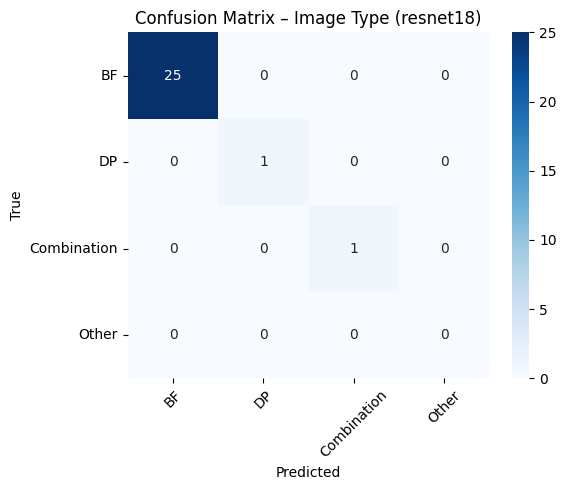


📊 Task: Nanostructures — Model: resnet18
              precision    recall  f1-score   support

   Few (<10)       0.67      0.40      0.50         5
  Many (>10)       0.00      0.00      0.00         0
          No       0.75      0.90      0.82        10
         One       0.00      0.00      0.00         3

    accuracy                           0.61        18
   macro avg       0.35      0.33      0.33        18
weighted avg       0.60      0.61      0.59        18



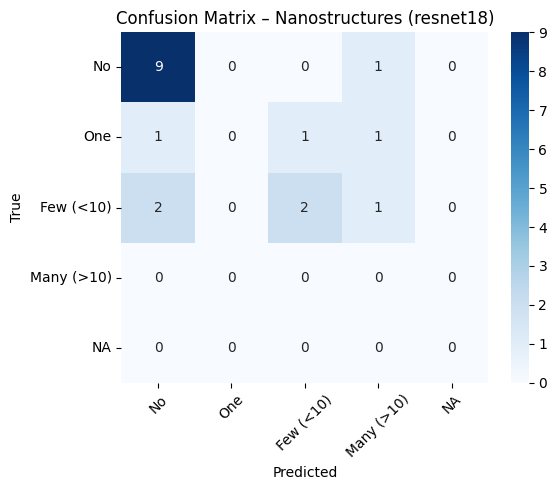


📊 Task: Morphology — Model: resnet18
                                  precision    recall  f1-score   support

                     Combination       0.50      0.75      0.60         8
                           Other       0.33      1.00      0.50         3
Thin flat or wavy with few kinks       0.00      0.00      0.00        10

                        accuracy                           0.43        21
                       macro avg       0.28      0.58      0.37        21
                    weighted avg       0.24      0.43      0.30        21



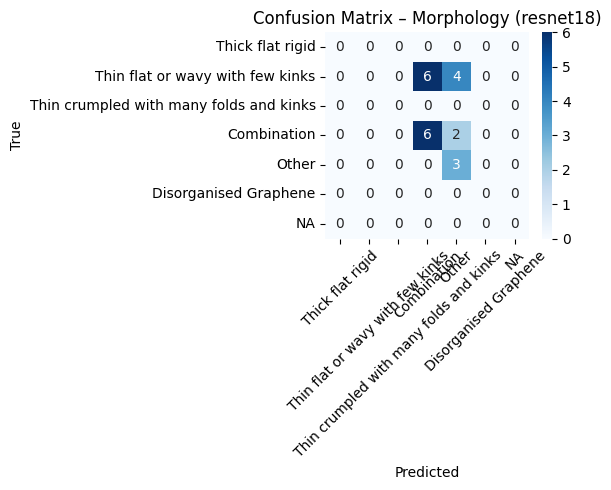


📊 Task: Num_particles — Model: resnet18
                     precision    recall  f1-score   support

       Few (2...10)       0.00      0.00      0.00         0
         Many (>10)       1.00      1.00      1.00         5
Part of one or more       1.00      0.90      0.95        20

           accuracy                           0.92        25
          macro avg       0.67      0.63      0.65        25
       weighted avg       1.00      0.92      0.96        25



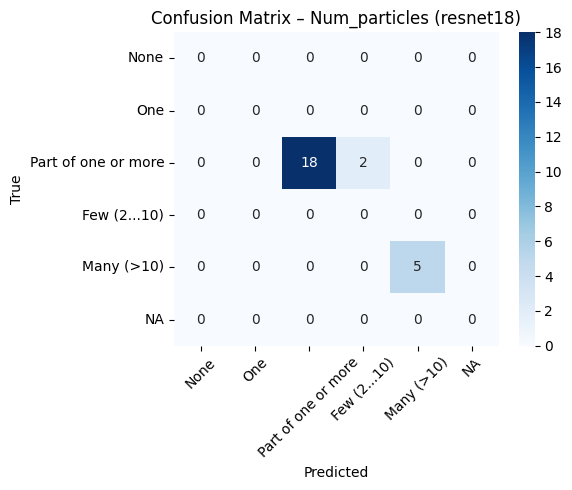


📊 Task: Num_materials — Model: resnet18
               precision    recall  f1-score   support

More than one       0.62      1.00      0.76         8
          One       1.00      0.71      0.83        17

     accuracy                           0.80        25
    macro avg       0.81      0.85      0.79        25
 weighted avg       0.88      0.80      0.81        25



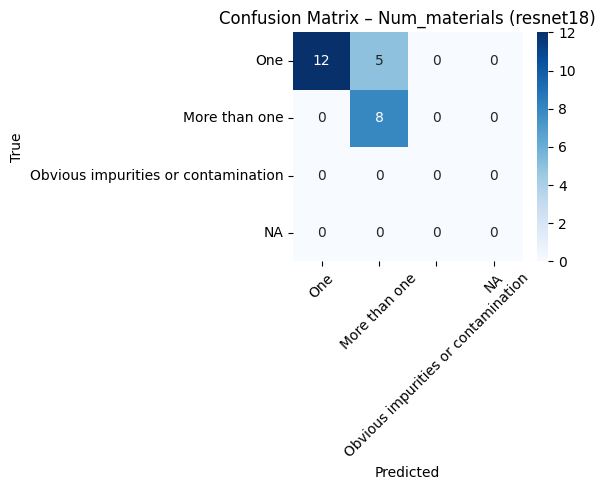


📊 Task: Usability — Model: resnet18
              precision    recall  f1-score   support

          No       0.00      0.00      0.00         1
         Yes       0.96      1.00      0.98        25

    accuracy                           0.96        26
   macro avg       0.48      0.50      0.49        26
weighted avg       0.92      0.96      0.94        26



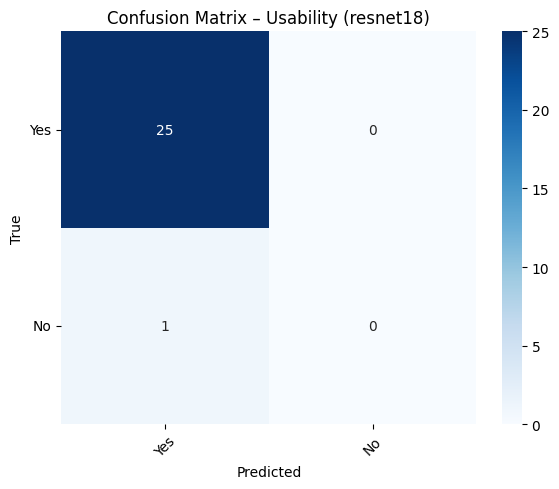

,Model,Task,Accuracy (%)
0,resnet18,Image Type,100.00
1,resnet18,Nanostructures,61.11
2,resnet18,Morphology,42.86
3,resnet18,Num_particles,92.00
4,resnet18,Num_materials,80.00
5,resnet18,Usability,96.15



📊 Task: Image Type — Model: efficientnet_b0
              precision    recall  f1-score   support

          BF       0.96      1.00      0.98        25
 Combination       0.00      0.00      0.00         1
          DP       1.00      1.00      1.00         1

    accuracy                           0.96        27
   macro avg       0.65      0.67      0.66        27
weighted avg       0.93      0.96      0.94        27



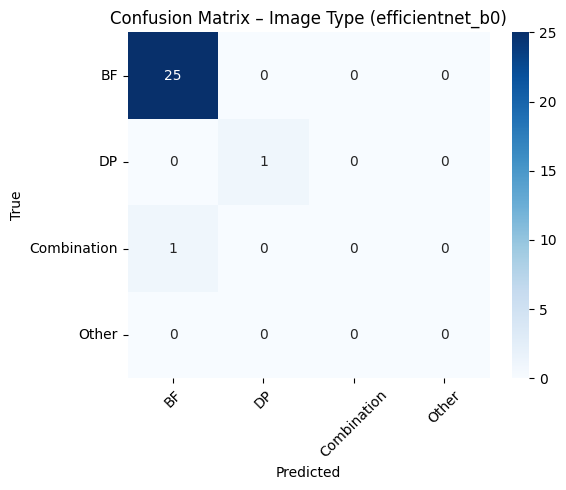


📊 Task: Nanostructures — Model: efficientnet_b0
              precision    recall  f1-score   support

   Few (<10)       1.00      0.20      0.33         5
  Many (>10)       0.00      0.00      0.00         0
          No       0.56      0.90      0.69        10
         One       0.00      0.00      0.00         3

    accuracy                           0.56        18
   macro avg       0.39      0.28      0.26        18
weighted avg       0.59      0.56      0.48        18



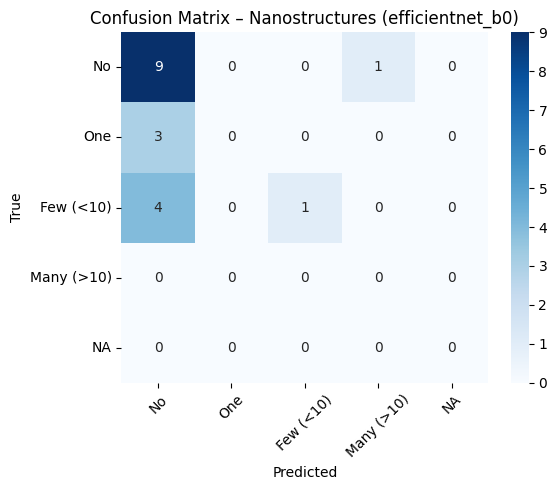


📊 Task: Morphology — Model: efficientnet_b0
                                  precision    recall  f1-score   support

                     Combination       0.43      0.75      0.55         8
                           Other       0.43      1.00      0.60         3
Thin flat or wavy with few kinks       0.00      0.00      0.00        10

                        accuracy                           0.43        21
                       macro avg       0.29      0.58      0.38        21
                    weighted avg       0.22      0.43      0.29        21



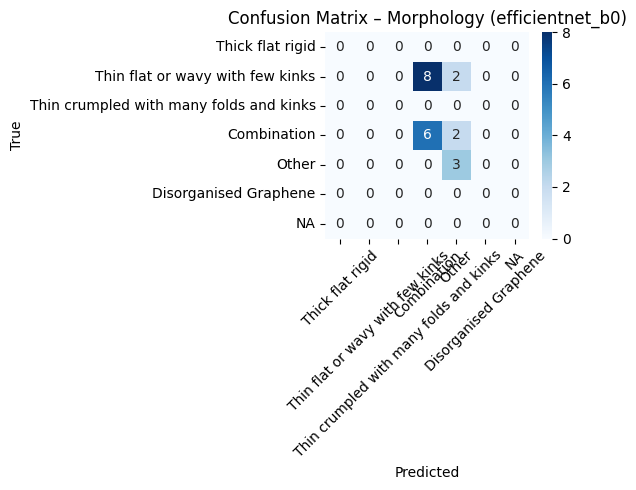


📊 Task: Num_particles — Model: efficientnet_b0
                     precision    recall  f1-score   support

         Many (>10)       1.00      0.80      0.89         5
Part of one or more       0.95      1.00      0.98        20

           accuracy                           0.96        25
          macro avg       0.98      0.90      0.93        25
       weighted avg       0.96      0.96      0.96        25



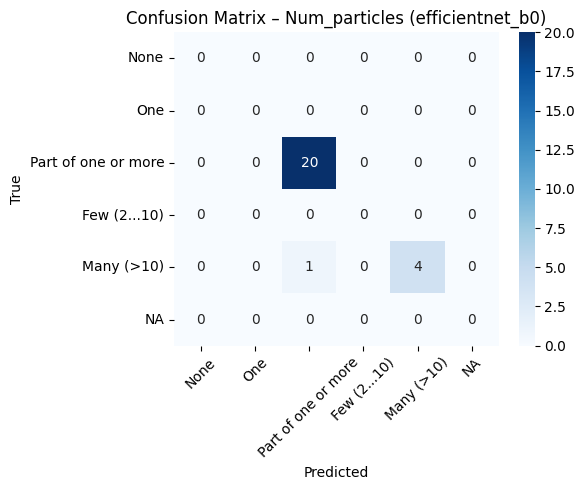


📊 Task: Num_materials — Model: efficientnet_b0
               precision    recall  f1-score   support

More than one       0.73      1.00      0.84         8
          One       1.00      0.82      0.90        17

     accuracy                           0.88        25
    macro avg       0.86      0.91      0.87        25
 weighted avg       0.91      0.88      0.88        25



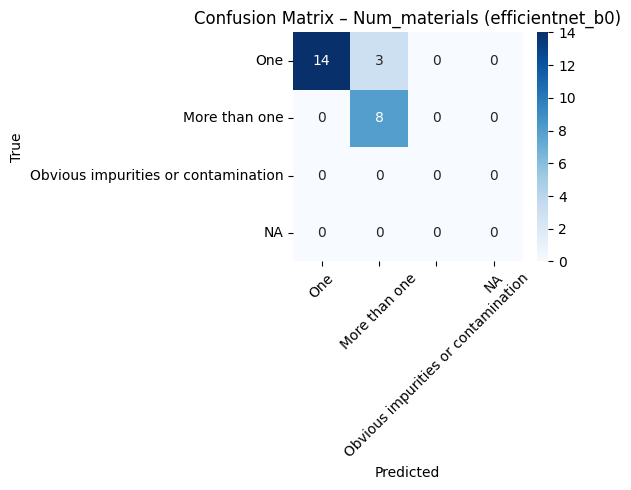


📊 Task: Usability — Model: efficientnet_b0
              precision    recall  f1-score   support

          No       0.00      0.00      0.00         1
         Yes       0.96      1.00      0.98        25

    accuracy                           0.96        26
   macro avg       0.48      0.50      0.49        26
weighted avg       0.92      0.96      0.94        26



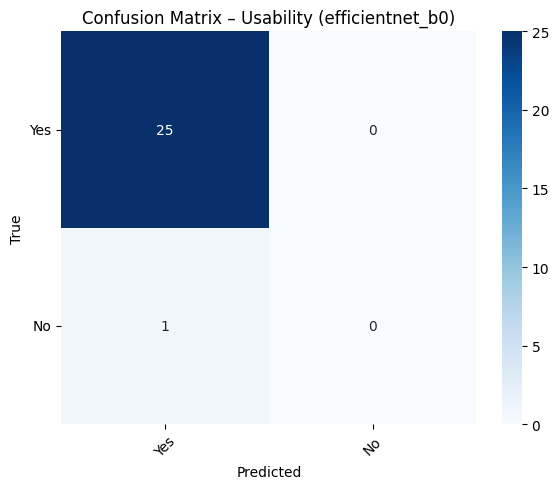

,Model,Task,Accuracy (%)
0,efficientnet_b0,Image Type,96.30
1,efficientnet_b0,Nanostructures,55.56
2,efficientnet_b0,Morphology,42.86
3,efficientnet_b0,Num_particles,96.00
4,efficientnet_b0,Num_materials,88.00
5,efficientnet_b0,Usability,96.15



📊 Task: Image Type — Model: convnext_tiny
              precision    recall  f1-score   support

          BF       0.96      1.00      0.98        25
 Combination       0.00      0.00      0.00         1
          DP       1.00      1.00      1.00         1

    accuracy                           0.96        27
   macro avg       0.65      0.67      0.66        27
weighted avg       0.93      0.96      0.94        27



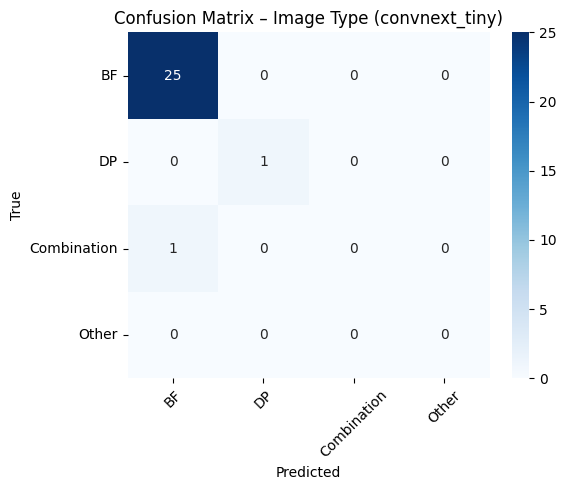


📊 Task: Nanostructures — Model: convnext_tiny
              precision    recall  f1-score   support

   Few (<10)       0.00      0.00      0.00         5
  Many (>10)       0.00      0.00      0.00         0
          No       0.56      0.90      0.69        10
         One       0.00      0.00      0.00         3

    accuracy                           0.50        18
   macro avg       0.14      0.23      0.17        18
weighted avg       0.31      0.50      0.38        18



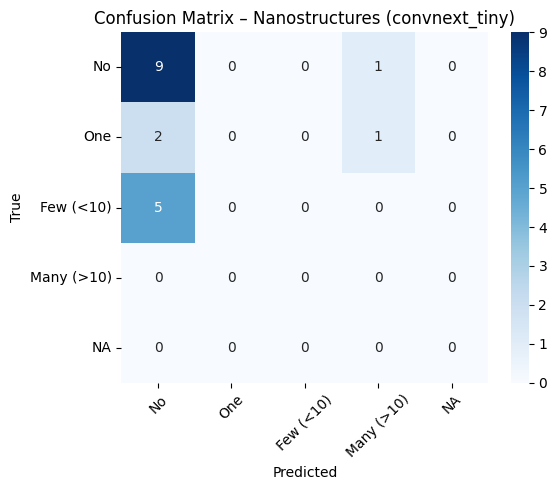


📊 Task: Morphology — Model: convnext_tiny
                                  precision    recall  f1-score   support

                     Combination       0.43      0.75      0.55         8
                           Other       0.43      1.00      0.60         3
Thin flat or wavy with few kinks       0.00      0.00      0.00        10

                        accuracy                           0.43        21
                       macro avg       0.29      0.58      0.38        21
                    weighted avg       0.22      0.43      0.29        21



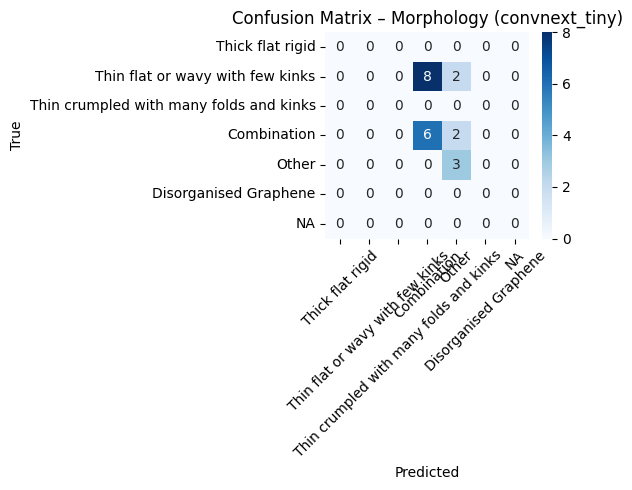


📊 Task: Num_particles — Model: convnext_tiny
                     precision    recall  f1-score   support

       Few (2...10)       0.00      0.00      0.00         0
         Many (>10)       1.00      0.80      0.89         5
Part of one or more       1.00      0.90      0.95        20

           accuracy                           0.88        25
          macro avg       0.67      0.57      0.61        25
       weighted avg       1.00      0.88      0.94        25



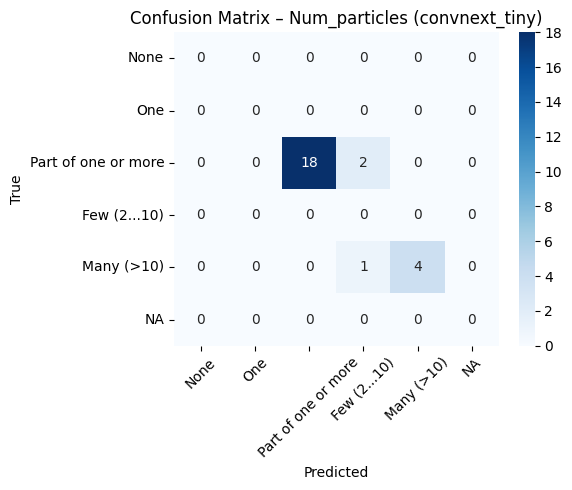


📊 Task: Num_materials — Model: convnext_tiny
               precision    recall  f1-score   support

More than one       0.73      1.00      0.84         8
          One       1.00      0.82      0.90        17

     accuracy                           0.88        25
    macro avg       0.86      0.91      0.87        25
 weighted avg       0.91      0.88      0.88        25



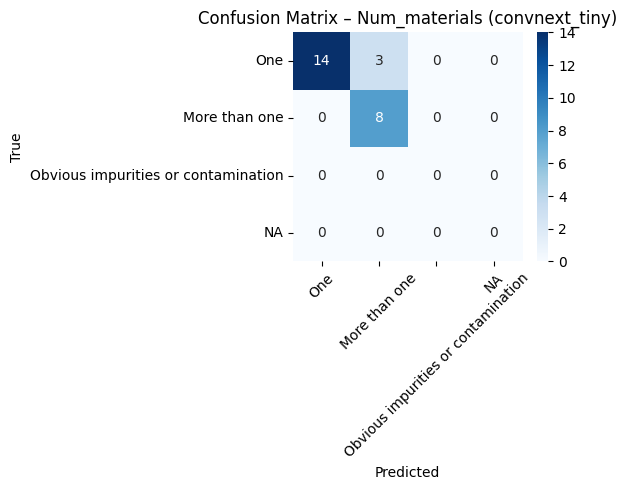


📊 Task: Usability — Model: convnext_tiny
              precision    recall  f1-score   support

          No       0.00      0.00      0.00         1
         Yes       0.96      1.00      0.98        25

    accuracy                           0.96        26
   macro avg       0.48      0.50      0.49        26
weighted avg       0.92      0.96      0.94        26



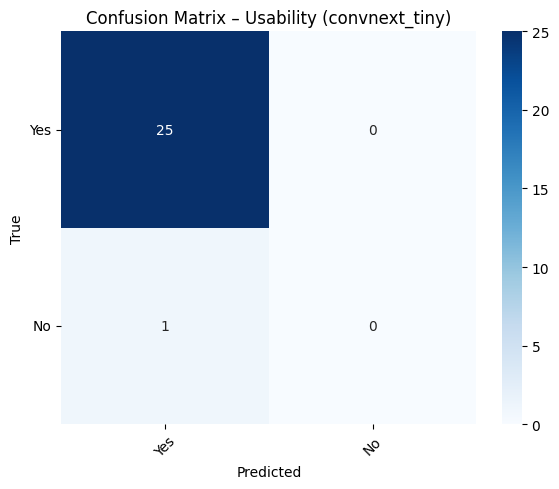

,Model,Task,Accuracy (%)
0,convnext_tiny,Image Type,96.30
1,convnext_tiny,Nanostructures,50.00
2,convnext_tiny,Morphology,42.86
3,convnext_tiny,Num_particles,88.00
4,convnext_tiny,Num_materials,88.00
5,convnext_tiny,Usability,96.15


In [16]:
all_results = []

for name, model in trained_models.items():
    df = evaluate_model(model, val_loader, backbone_name=name)
    all_results.append(df)

<Figure size 800x600 with 0 Axes>

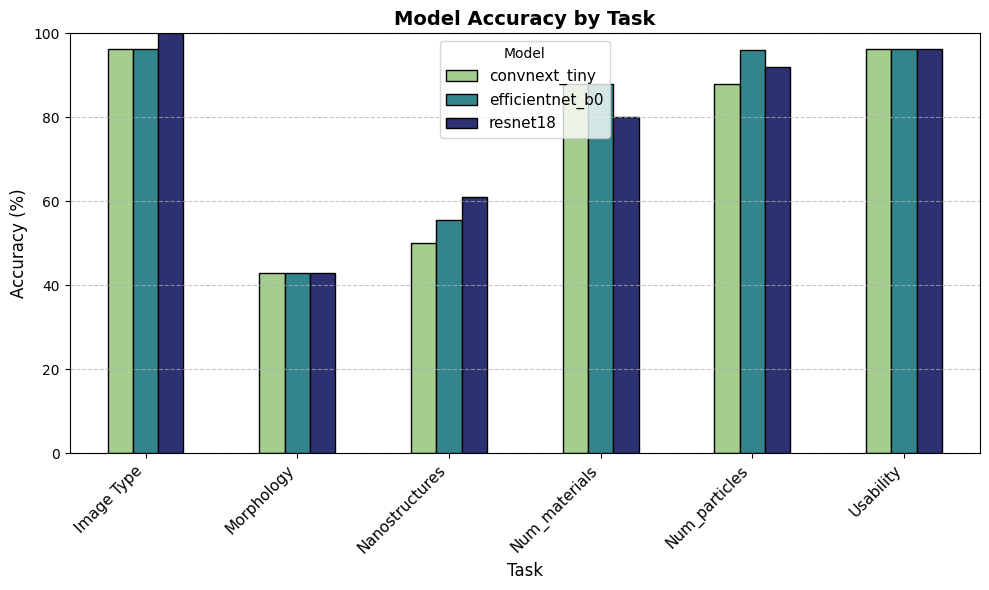

In [24]:
results_df = pd.concat(all_results, ignore_index=True)
results_df.pivot(index="Task", columns="Model", values="Accuracy (%)")


<Figure size 800x600 with 0 Axes>

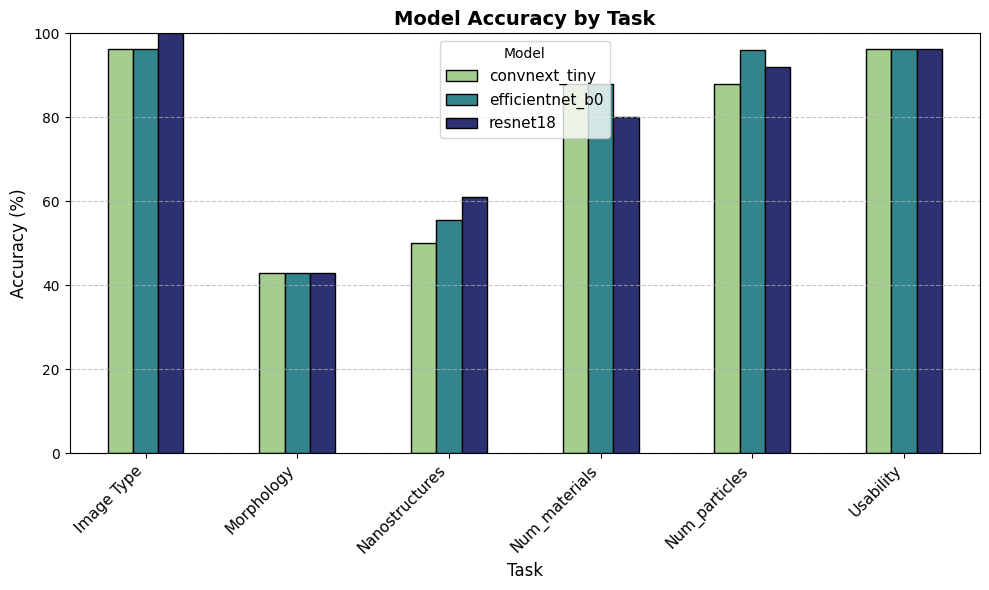

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# pivot do wygodnego formatu
pivot_df = results_df.pivot(index="Task", columns="Model", values="Accuracy (%)")

plt.figure(figsize=(8, 6))
pivot_df.plot(kind="bar", figsize=(10, 6), colormap="crest", edgecolor="black")

plt.title("Model Accuracy by Task", fontsize=14, weight="bold")
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xlabel("Task", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=11)
plt.legend(title="Model", fontsize=11)
plt.ylim(0, 100)  # bo accuracy w %
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# 🚀 Step 8: Run inference on test images and save predictions

This step performs the following:
- Loads test images from each folder in `TEST_DIRS`,
- Uses the trained model to predict labels for all tasks,
- Decodes label indices into human-readable text (e.g. "Yes", "Thin crumpled", etc.),
- Saves:
  - a `.csv` file with predictions per image in `/processed/<material>/`,
  - labeled versions of the images with overlaid predictions in `/processed/<material>/with_labels/`.


In [18]:
# Select best model based on average accuracy
mean_acc = results_df.groupby("Model")["Accuracy (%)"].mean()
best_model_name = mean_acc.idxmax()
print(f"🏆 Best model: {best_model_name} with avg accuracy {mean_acc.max():.2f}%")

# Load the best model
best_model = trained_models[best_model_name]

🏆 Best model: efficientnet_b0 with avg accuracy 79.14%


In [19]:
import os
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
from pathlib import Path

# 🔁 Reuse transforms from validation
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

model = best_model
model.eval()

# Define idx2label here to be accessible
idx2label = {
    task: {i: label for i, label in enumerate(CLASS_LABELS[task])}
    for task in CLASS_LABELS
}


for test_dir in TEST_DIRS:
    folder_name = Path(test_dir).name
    image_paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir)
                   if f.lower().endswith(('.tif', '.png', '.jpg', '.jpeg'))]

    results = []

    output_folder = os.path.join(OUTPUT_BASE_DIR, folder_name)
    labeled_img_dir = os.path.join(output_folder, "with_labels")
    os.makedirs(labeled_img_dir, exist_ok=True)

    for img_path in tqdm(image_paths, desc=f"🔎 Predicting: {folder_name}"):
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"⚠️ Failed to open image: {img_path} – {e}")
            continue

        input_tensor = transform(image).unsqueeze(0).to(DEVICE)

        # Extract and prepare magnification
        magnification = extract_magnification(img_path)
        magnification_tensor = torch.tensor([[magnification]], dtype=torch.float32).to(DEVICE)


        with torch.no_grad():
            output = model(input_tensor, magnification_tensor) # Pass both inputs

        # Decode predictions
        predictions = {
            task: idx2label[task][torch.argmax(output[task], dim=1).item()]
            for task in CLASS_LABELS
        }

        # Store CSV result
        results.append({
            "filename": os.path.basename(img_path),
            **predictions
        })

        # Overlay on image
        draw = ImageDraw.Draw(image)
        y = 10
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 18)
        except:
            font = ImageFont.load_default()

        for task, label in predictions.items():
            draw.text((10, y), f"{task}: {label}", fill="red", font=font)
            y += 22

        image.save(os.path.join(labeled_img_dir, os.path.basename(img_path)))

    # Save CSV
    df = pd.DataFrame(results)
    csv_path = os.path.join(output_folder, f"{folder_name}_predictions.csv")
    df.to_csv(csv_path, index=False)
    print(f"✅ Saved predictions: {csv_path}")
    print(f"🖼️ Labeled images saved in: {labeled_img_dir}")

🔎 Predicting: AC_UT_G_03_01_TEM: 100%|██████████| 81/81 [01:39<00:00,  1.23s/it]


✅ Saved predictions: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/processed/AC_UT_G_03_01_TEM/AC_UT_G_03_01_TEM_predictions.csv
🖼️ Labeled images saved in: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/processed/AC_UT_G_03_01_TEM/with_labels


🔎 Predicting: AC_UT_G_04_01_TEM: 100%|██████████| 54/54 [01:06<00:00,  1.23s/it]


✅ Saved predictions: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/processed/AC_UT_G_04_01_TEM/AC_UT_G_04_01_TEM_predictions.csv
🖼️ Labeled images saved in: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/processed/AC_UT_G_04_01_TEM/with_labels


🔎 Predicting: AC_UT_GO_02_02_UO_TEM: 100%|██████████| 40/40 [00:27<00:00,  1.43it/s]


✅ Saved predictions: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/processed/AC_UT_GO_02_02_UO_TEM/AC_UT_GO_02_02_UO_TEM_predictions.csv
🖼️ Labeled images saved in: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/processed/AC_UT_GO_02_02_UO_TEM/with_labels


🔎 Predicting: AC_UT_GO_02_03_UO_TEM: 100%|██████████| 49/49 [00:34<00:00,  1.41it/s]


✅ Saved predictions: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/processed/AC_UT_GO_02_03_UO_TEM/AC_UT_GO_02_03_UO_TEM_predictions.csv
🖼️ Labeled images saved in: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/processed/AC_UT_GO_02_03_UO_TEM/with_labels


🔎 Predicting: AC_UT_GO_09_03_F_02_TEM: 100%|██████████| 64/64 [00:41<00:00,  1.56it/s]


✅ Saved predictions: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/processed/AC_UT_GO_09_03_F_02_TEM/AC_UT_GO_09_03_F_02_TEM_predictions.csv
🖼️ Labeled images saved in: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/processed/AC_UT_GO_09_03_F_02_TEM/with_labels


🔎 Predicting: AC_UT_GO_06_01_F_01_TEM: 100%|██████████| 47/47 [00:31<00:00,  1.47it/s]


✅ Saved predictions: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/processed/AC_UT_GO_06_01_F_01_TEM/AC_UT_GO_06_01_F_01_TEM_predictions.csv
🖼️ Labeled images saved in: /content/drive/MyDrive/02 ACCORDS/ACC_ImageCharacterisation/data/test_dataset_classification/processed/AC_UT_GO_06_01_F_01_TEM/with_labels
